### Making and Using Clusters:
 - Goals:
 - utilize sklearn to create KMeans clusters, and investigate *how to make them useful*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


In [2]:
# let's grab the mall data again:
df = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/cc276eea59e8295204d1f581c8da509f/raw/2388559aef7a0700eb31e7604351364b16e99653/mall_customers.csv', index_col="customer_id")

In [3]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


#### Quick takeaways from this data set:
 - Gender is not a good candidate for KMeans Clustering.  It is not continuous information (its categorical) and will not provide a ton of value with this specific clustering algorithm
 - This does not necessarily mean that Gender is not a good candidate for observations about these customers.  Proper analysis and exploration will allow us to provide utility based on our familiar methods of visual exploration and statistical testing

In [5]:
df.groupby('gender').agg(
    ['min', 'max', 'median', 'std', 'mean']).T

gender                     Female        Male
age            min      18.000000   18.000000
               max      68.000000   70.000000
               median   35.000000   37.000000
               std      12.644095   15.514812
               mean     38.098214   39.806818
annual_income  min      16.000000   15.000000
               max     126.000000  137.000000
               median   60.000000   62.500000
               std      26.011952   26.638373
               mean     59.250000   62.227273
spending_score min       5.000000    1.000000
               max      99.000000   97.000000
               median   50.000000   50.000000
               std      24.114950   27.896770
               mean     51.526786   48.511364

 - On initial observation of the descriptive stats for these groups in gender, I'm not seeing immediate disparity. 
 - In order to certify this further I would want to utlize a bit more exploratory data analysis (viz and stats testing)
 - In the meantime, for my modeling MVP, I am going to proceed with the continuous features that I have present and continue assessing them as appropriate

In [10]:
# long and short: I'm going to ignore gender for now.
# example note: 
# in production I would not just be yeeting this info
df = df.drop(columns='gender')

In [7]:
df

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [11]:
# example thing again: I'm just going to claim that this is my training
# set rather than actually splitting it

train = df.copy()

In [12]:
train

,age,annual_income,spending_score
customer_id,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
...,...,...,...
196,35,120,79
197,45,126,28
198,32,126,74


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             200 non-null    int64
 1   annual_income   200 non-null    int64
 2   spending_score  200 non-null    int64
dtypes: int64(3)
memory usage: 14.4 KB


In [14]:
# train is already clean -- no extra need for imputation here
# everything is numerical and filled

In [16]:
# apply scaling so that my distance based algorithms
# will properly observe the data present
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
train_scaled = pd.DataFrame(
    scaler.fit_transform(train),
    index = train.index,
    columns = train.columns)


In [17]:
train_scaled

,age,annual_income,spending_score
customer_id,,,
1,0.019231,0.000000,0.387755
2,0.057692,0.000000,0.816327
3,0.038462,0.008197,0.051020
4,0.096154,0.008197,0.775510
5,0.250000,0.016393,0.397959
...,...,...,...
196,0.326923,0.860656,0.795918
197,0.519231,0.909836,0.275510
198,0.269231,0.909836,0.744898


Lets observe this visually to re-assess if there is any utility in clustering for this specific case

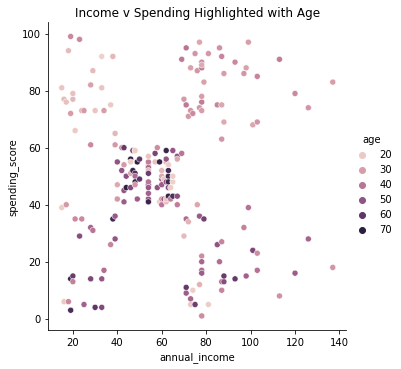

In [18]:
sns.relplot(
    data=train, 
    x='annual_income', 
    y='spending_score', hue='age').set(
    title='Income v Spending Highlighted with Age');

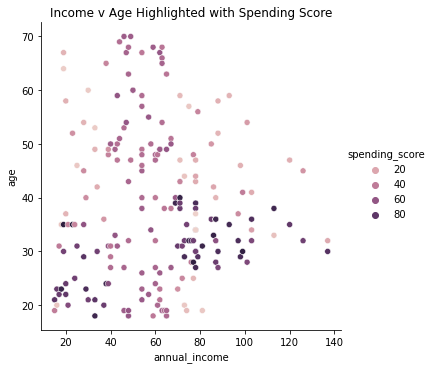

In [19]:
sns.relplot(
    data=train, 
    x='annual_income', 
    y='age', hue='spending_score').set(
    title='Income v Age Highlighted with Spending Score');

#### Basic visualization and exploratory takeaways:
 - spending_score and income seem to be driving segments of customers in this specific case.
 - age does not seem to be as relevant.  There are observable patterns in that older customers appear to genderally have a slightly lower spending score, but not totally consistently.

In [21]:
# let's make an initial sklearn object 
# to create a cluster label
kmeans = KMeans(n_clusters=5)
kmeans.fit(train_scaled)
train['cluster'] = kmeans.predict(train_scaled)

In [33]:
train_scaled['cluster'] = kmeans.predict(train_scaled)

In [22]:
train.cluster.value_counts()

3    58
4    49
0    40
2    30
1    23
Name: cluster, dtype: int64

## New thing: The Elbow Method
 - The elbow method allows us to examine the average residual from any given centroid out to its population of data points.
 - If one cluster provides us with our maximum possible interia, and n clusters (n being every row of data) clusters provides us with zero inertia, there should be a sweet spot where we experience dropoff

 - Vocabulary:
 - *inertia*: residual error sums of the clusters
 - *k*: number of clusters established
 - *centroid*: the anchor point of any given K-Means cluster

In [24]:
kmeans.inertia_

10.303964892534129

In [26]:
# quick comprehension recap
# previously with lists:
# we define an iterable and cram a for-loop
# into brackets to generate a list
[x for x in range(0,5)]

[0, 1, 2, 3, 4]

In [29]:
# we can do the exact same thing with a dictionary,
# we merely need to define a key/value pair
{f'number {x}': x for x in range(0,5)}

{'number 0': 0, 'number 1': 1, 'number 2': 2, 'number 3': 3, 'number 4': 4}

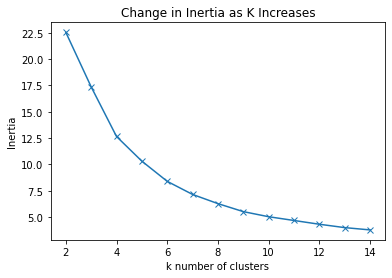

In [32]:
# let's use a dictionary 
# comprehension to associate the number of clusters
# with the intertia for that specific Kmeans model
pd.Series(
    {k: KMeans(k).fit(train_scaled).inertia_ 
     for k in range(2,15)}).plot(marker='x')
plt.ylabel('Inertia')
plt.xlabel('k number of clusters')
plt.title('Change in Inertia as K Increases')
plt.show()


In [34]:
train_scaled.head()

,age,annual_income,spending_score,cluster
customer_id,,,,
1,0.019231,0.000000,0.387755,4
2,0.057692,0.000000,0.816327,1
3,0.038462,0.008197,0.051020,4
4,0.096154,0.008197,0.775510,1
5,0.250000,0.016393,0.397959,4


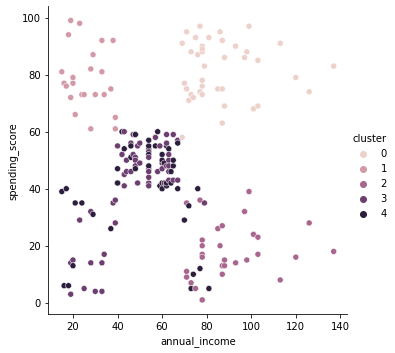

In [35]:
sns.relplot(data=train, 
            x='annual_income', 
            y='spending_score',
           hue='cluster');

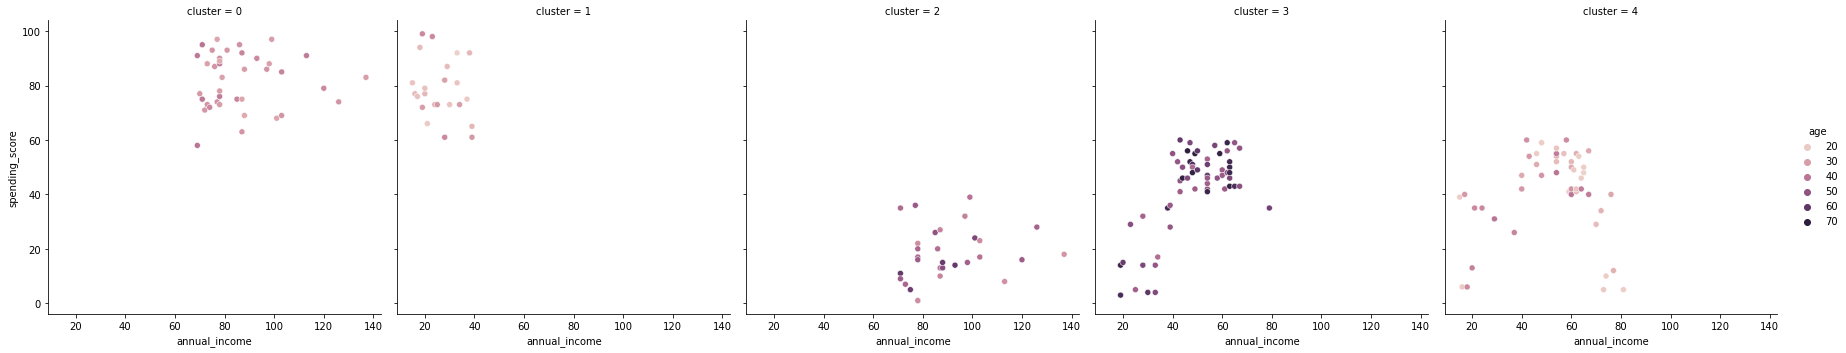

In [36]:
sns.relplot(data=train,
           x='annual_income',
           y='spending_score',
           hue='age',
           col='cluster')

In [38]:
# let's give some extra value to our clusters
# (lets name them)
train.cluster = train.cluster.map(
{
    0: 'targets',
    1: 'young-thrifty',
    2: 'older-frugals',
    3: 'older-general',
    4: 'younger-general'
})

In [41]:
train.head()

,age,annual_income,spending_score,cluster
customer_id,,,,
1,19,15,39,younger-general
2,21,15,81,young-thrifty
3,20,16,6,younger-general
4,23,16,77,young-thrifty
5,31,17,40,younger-general


In [42]:
train.groupby('cluster').agg(
    ['min', 'max', 'mean'])

age                annual_income                  \
                min max       mean           min  max       mean   
cluster                                                            
older-frugals    32  59  44.000000            71  137  90.133333   
older-general    42  70  55.551724            19   79  48.482759   
targets          27  40  32.875000            69  137  86.100000   
young-thrifty    18  35  25.521739            15   39  26.304348   
younger-general  18  40  27.061224            15   81  51.979592   

                spending_score                 
                           min max       mean  
cluster                                        
older-frugals                1  39  17.933333  
older-general                3  60  41.775862  
targets                     58  97  81.525000  
young-thrifty               61  99  78.565217  
younger-general              5  60  41.040816

## Takeaways:

### Roads to take from here:
 Further explore the disparities and similarities in these groups and/or customer segments!
 Run statistical tests! Do More Exploration!(TM)

 - Explore further on the segments (does gender play a role in these individual segments where it did not before?)
 - Model for the segments (predict what type of spender someone is)
 - Model using the segments as a feature with some target
 - 